### Statistical Questions - Caleb Wilkins 10/24/2021

This notebook features and in-depth walkthrough of the scientific process of going from a statistical question to a mathematical expression to an algorithmic solution. It begins by using a simple simulated example, with no unknowns, then transitions to a real world astronomical example of scientific data analysis. 

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, signal
plt.rcParams["figure.figsize"] = (15,10)

   In statistics, the act of "asking a question" is a much more complex and critical step of the process than it appears based on its simple wording. So much so, in fact, that perfecting the question one is asking and translating it into appropriate mathematics and models often takes up much more time and energy than what most would consider the actual "science" part of the process (collecting potential signal data, etc). 
   
   Though it is an imperative step, it can be boiled down by the following three steps: 1) Writing down in words very precisely what question you are trying to ask. 2) Translating the precise question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and then determining the correct integral to do to obtain a probability. 3) Converting the probability into equivalent sigma.

   In this notebook we will be going through this process a few times to gain experience with it through repitition.
   
   In our first example, we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be around 12 Kelvin (mean), and if we look at the data it is mostly consistent with 12 Kelvin within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 Kelvin, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.
   
   To make this a bit more concrete, we will simulate a little data. We start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god, adding the following 'bad' datapoints: [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]

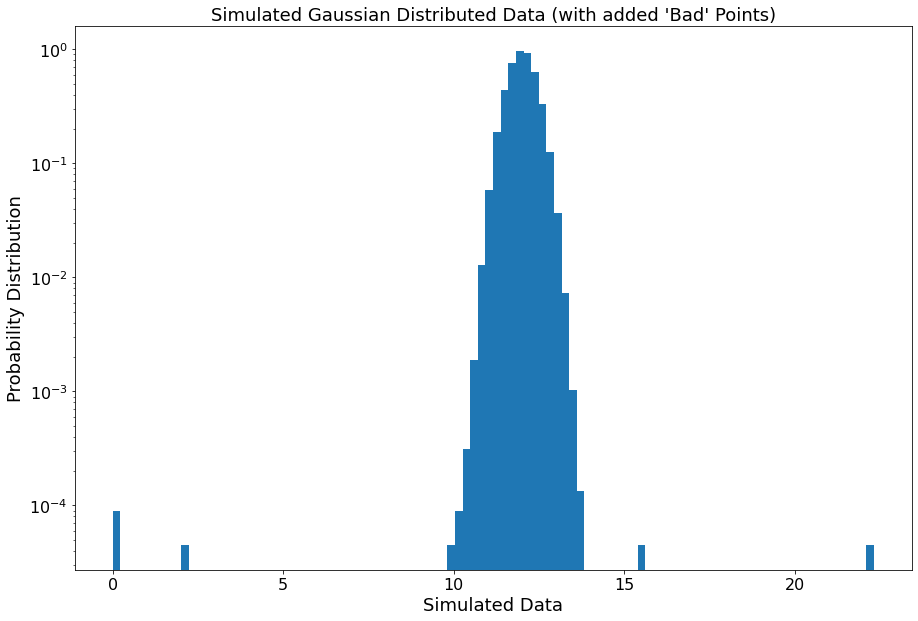

In [2]:
# We start by creating a variable that is an array containing 100k normally distributed
# data points, with the addition of the 'bad' data points

all_data = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])

plt.hist(all_data,100, density=True)
plt.ylabel("Probability Distribution", fontsize=18)
plt.xlabel("Simulated Data", fontsize=18)
plt.title("Simulated Gaussian Distributed Data (with added 'Bad' Points)", fontsize=18)
plt.tick_params(labelsize = 16)
plt.yscale('log')
plt.show()

Our goal thus becomes identifying the bad data and excluding it from our distribution so that we may do accurate science. We will first plot our data on top of a normal distribution with mean 12 and standard deviation 0.4 in order to explore how closely it is approximated by a normal distribution.

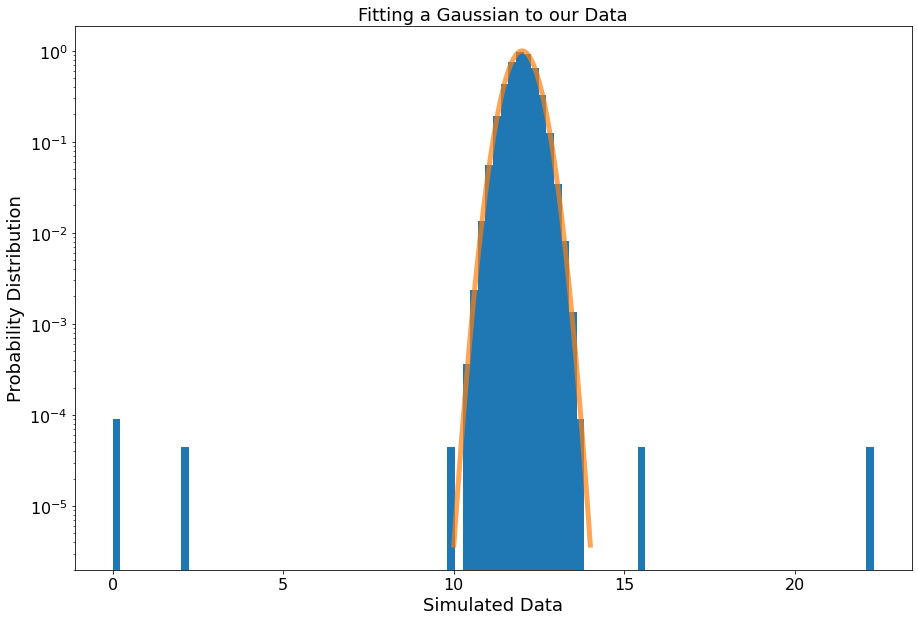

In [3]:
all_data = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(all_data,100, density=True)
plt.tick_params(labelsize = 16)
plt.title("Fitting a Gaussian to our Data", fontsize = 18)
plt.ylabel("Probability Distribution", fontsize = 18)
plt.xlabel("Simulated Data", fontsize=18)
plt.yscale('log')
x = np.linspace(10,14,1000)
ax.plot(x,stats.norm.pdf(x,loc = 12, scale = 0.4),linewidth = 5,alpha = 0.7)
plt.show()

Now, to eliminate the "bad" data points (that we added ourselves in order to do this exercise), we formulate our statistical question. First, we state it in words. We are asking: What data points have a probability of occuring within a 5$\sigma$ range of the mean of the normal distributionm associated with our data? We then translate this question to math. To calculate mathematically, we would evaluate the inequality:
$$ \frac{x - \mu}{\sigma} > 5 $$
Note the orientation of the "greater than" sign, because we are going to focus on which data points to eliminate since there are magnitudes fewer than the ones we want to keep.

We want to create an algorithm that will test if a particular data point falls outside a 5$\sigma$ range of the mean of our distribution, which will then throw out such data points. 

In [4]:
# The following function is designed to perform the test we just described above,
# which it accpomplishes by utilizing the mathematical expression shown above 

# The arguments it takes are 'x' - which in this case will be the array of our data 
# The 'mean' argument is the specified mean of the distribution
# The 'standard_deviation' argument is the specified standard deviation of the distribution
# These are the necessary arguments needed to perform a sigma threshold test

def sigma_threshold_test(x, mean, standard_deviation):
    threshold = (x - mean) / standard_deviation
    if abs(threshold) <= 5:
        return True
    else:
        return False

Our strategy becomes using the function we created to loop through our data and determine point by point if it meets our sigma threshold. We will then append each point to new arrays that will allow us to construct a 'truth table' that will show how accurate our algorithm is in determining good data from bad data. 

In [5]:
added_bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]

# We will append to this array if our function output is "True" (or, the data point is deemed good)
good_data = [] 

# We will append to this array if our function output is "False" (or, the data point is deemed bad)
bad_data = [] 

# We will append to this array our function deems the data point good AND if it DOES NOT exist in 
# the 'added_bad_data' array
true_good = []

# We will append to this array our function deems the data point good AND if it DOES exist in 
# the 'added_bad_data' array
false_good = []

# We will append to this array our function deems the data point bad AND if it DOES exist in 
# the 'added_bad_data' array
true_bad = []

# We will append to this array our function deems the data point bad AND if it DOES NOT exist in 
# the 'added_bad_data' array
false_bad = []

for d in all_data:
    if sigma_threshold_test(d, 12, 5) == True:
        good_data.append(d)
        if d in added_bad_data:
            false_good.append(d)
        else:
            true_good.append(d)
            
    else:
        bad_data.append(d)
        if d not in added_bad_data:
            false_bad.append(d)
        else:
            true_bad.append(d)
            
len(true_good), len(false_good), len(true_bad), len(false_bad)        

(100000, 8, 0, 0)

Thus, we construct our truth table as follows:

||True Good|True Bad|
|---|---|---|
|Test Good|100000|0|
|Test Bad|0|8|
|Total|100000|8|

Using a sigma threshold of 5$\sigma$, we successfully included only good data and only excluded bad data. However, this was "lucky" (or, it would be without our prior knowledge of the distribution), and had we chosen a different sigma threshold, we would have seen either an inclusion of bad data or an exclusion of good data.

Note: According to our model and truth table, our test successfully sorted good data points from bad ones. However, I wonder about the "bad" data points we added that also fall within the "good" data distribution (such as 12.7), as I am uncertain if they were truly excluded or flew under the radar of our algorithm somehow. 

##### Real World Application
Next, we will be testing the application of this scientific analysis method by looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for simplicity let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if we histogram how far all the (stationary) stars appear to have moved we get something like the following:

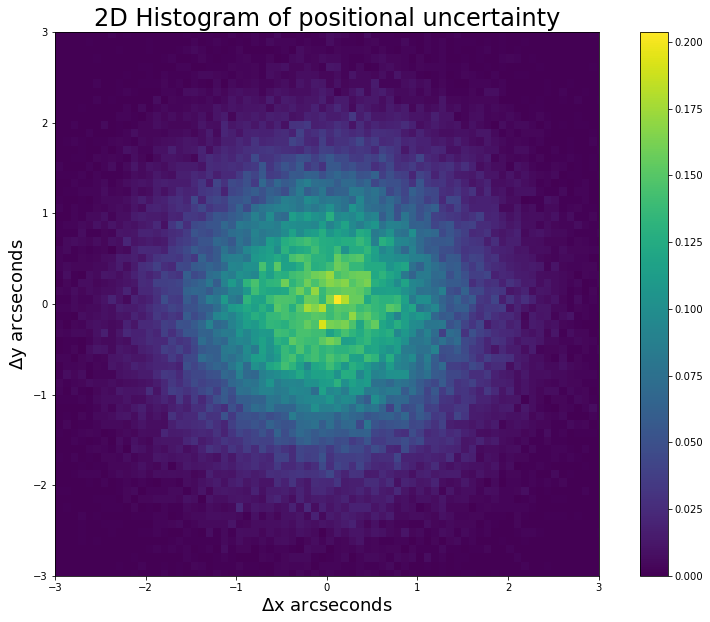

In [6]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax);

This time, the question we are asking is: What is the distance away from the origin at which the 2-dimensional Gaussian background might produce a position measurement that has a significance of $5\sigma$?

We know that 2D vector distributions have Rayleigh distributed Probability Density Functions. Thus, we can translate our statistical question into math as follows:

We need to find a mathematical representation of our two-dimensional PDF. Because it is a Gaussian PDF in two dimensions, the form is $PDF(x, y) = e^{-\frac{1}{2} \left( x^2 + y^2 \right)}$. To integrate this PDF, we first convert to polar coordinates: $PDF(r) = e^{-\frac{1}{2} r^2}$, then to integrate between $r = a$ and $r = b$ in polar coordinates we multiply the PDF by $r$ like so: $\int \limits_{0}^{2\pi} \int \limits_{a}^{b} re^{-\frac{1}{2} r^2} drd\theta$. If we integrate the function for $0 < r < \infty$, we get $2\pi$, so the probability of $r$ falling within $a$ and $b$ is given by $P(a < r < b) = \int \limits_{a}^{b} re^{-\frac{1}{2} r^2} dr$, the previous integral divided by $\int \limits_{0}^{2\pi} d\theta$, which is $2\pi$.

Given that $5\sigma$ corresponds to a probability of about $2.867\times10^{-7}$, our statistical question converted to math is: What is the value $a$ such that $P(a < r < \infty) = 2.867\times10^{-7}$?

The new PDF in the integrand now represents that of a Rayleigh distributed variable, so we can use the ppf function on a Rayleigh distribution of standard deviation 1 arc-second to find the value at which we find a measurement of $5\sigma$ significance.

In [7]:
distribution_2D = stats.rayleigh(scale=1)
distance = distribution_2D.ppf(stats.norm.cdf(5))

print(f'The angular distance required for a 5 sigma movement detection is about {distance:.2f} arc-seconds.')

The angular distance required for a 5 sigma movement detection is about 5.49 arc-seconds.


One of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles — usually protons or electrons, but can include atomic nuclei such alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

We will assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

If we measure the counts for an 8-hour interval, we expect to see an average of $8 \cdot 60 = 480$ cosmic rays during those 8 hours. The observations in an 8-hour time frame are represented by a Poisson distribution with a mean of $\lambda = 480$. Now, let us assume we take 15 days worth of measurements, which corresponds to 15 8-hour timeframes. Because there are 15 timeframes of data and the distribution of cosmic rays seen per minute does not vary between days, we can convolve each of the 15 datasets together, which gives a Poisson distribution with a mean of $15 \cdot 480 = 7200$ cosmic rays. We multiply the mean for the distribution of 1 day by 15 because the convolution of multiple Poisson distributions is itself a Poisson distribution with a mean equal to the sum of all the means of the convolved distributions.

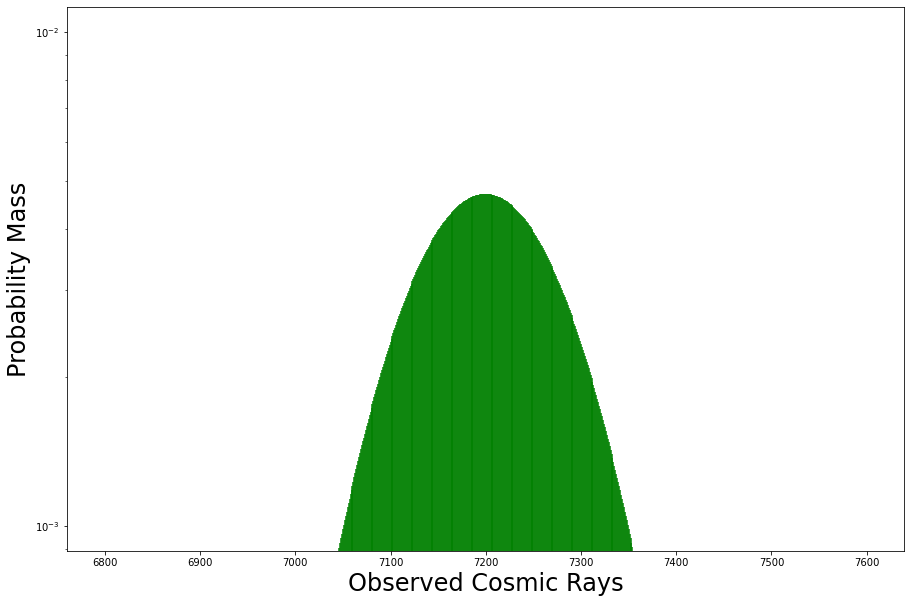

In [8]:
# Using scipy to create our distribution of known mean
our_dist = stats.poisson(7200)

# We know what range of values we are interested in due to our previous mathematical analysis
x = np.arange(6800, 7600)

# Since it is a Poisson distribution, we know to use the pmf rather than pdf
our_pmf = our_dist.pmf(x)

plt.xlabel("Observed Cosmic Rays", fontsize=24)
plt.ylabel("Probability Mass", fontsize=24)
plt.vlines(x, 0, our_pmf, color="g")
plt.yscale('log');

As expected, a Poisson distribution convolved with itself enough will approach an approximate Gaussian distribution, which we see here. 

If we observe for 15 days and see 6800 cosmic rays, we ask: what is the probability that the background data plotted above produced 6800 or less cosmic rays in 15 days?

To answer this question, we integrate the PMF of our background from 0 to 6800, and then convert it to a sigma value. The precise formula for the integration is 
$$P(k|\lambda)=e^{-\lambda}\sum\limits_{i=0}^{k}\frac{\lambda^i}{i!} \text{; where } \lambda = 7200 \text{ and } k=6800$$

In [9]:
our_prob = our_dist.cdf(6800)
our_sigma = abs(stats.norm.ppf(our_prob))

print(f'Thus, the significance of our moon shadow detection is {our_sigma:.2f} sigma.')

Thus, the significance of our moon shadow detection is 4.75 sigma.
